<a href="https://colab.research.google.com/github/farhanhubble/ml-experiments/blob/main/MNIST_Param_Evolution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Parameter Evolution
Study how the parameter weights of a simple deep network evolve during training. 

We train a small fully connected network on 48,000 MNIST images, validating on another 12,000 images and testing on 10,000 new images.

We plot the distributions of the model's paramter weights to see if the display any pattern. 

<span style="color:red;">In this simple setup, the weights are initially uniformly randomly distributed but converge to a normal distribution after training. </span>

### Load MNIST Train and Test Datasets
We do not perform any preprocessing right now because:
- We would like to split the training data into training and validation data.
- Compute the mean and standard deviation of the training data so obtained for normalization.

In [1]:
from torchvision import datasets

train_val_dataset = datasets.MNIST(root='./data/',
                            train=True,
                            download=True)

test_dataset = datasets.MNIST(root='./data',
                           train=False,
                           download =True)



  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



### Split Training Dataset
Create disjoint training and validation datasets.

In [2]:
from sklearn.model_selection import train_test_split 

indices = list(range(len(train_val_dataset)))

train_indices, val_indices = train_test_split(indices, test_size=0.3, 
                                              stratify=train_val_dataset.targets)

In [3]:
train_data, train_labels = train_val_dataset.data[train_indices], \
                           train_val_dataset.targets[train_indices]

valid_data, valid_labels = train_val_dataset.data[val_indices], \
                           train_val_dataset.targets[val_indices]

test_data, test_labels = test_dataset.data, test_dataset.targets

In [4]:
print(f'Training data shape:{train_data.shape}, Validation data shape: {valid_data.shape}')

Training data shape:torch.Size([42000, 28, 28]), Validation data shape: torch.Size([18000, 28, 28])


### Normalize Data
- Calculate normalization parameters from training data
- Normalize all three data
- Create Pytorch datasets

In [5]:
train_mean, train_std = train_data.float().mean(), train_data.float().std()
print(f'Training mean:{train_mean}, Traininig std. deviation: {train_std}')

Training mean:33.31146240234375, Traininig std. deviation: 78.56159973144531


In [6]:
from torchvision.transforms.functional import normalize
def transform_data(tensor):
  scaled_tensor = tensor.float() / 255.;
  return normalize(scaled_tensor,[train_mean/255], [train_std/255])


train_data_normalized = transform_data(train_data)
valid_data_normalized = transform_data(valid_data)
test_data_normalized = transform_data(test_data)


In [7]:
for dataset in [train_data_normalized, valid_data_normalized, test_data_normalized]:
  print(f'Min:{dataset.min():.3f}, Mean:{dataset.mean():.3f}, Max:{dataset.max():.3f}')

Min:-0.424, Mean:0.000, Max:2.822
Min:-0.424, Mean:0.000, Max:2.822
Min:-0.424, Mean:0.006, Max:2.822


In [8]:
from torch.utils.data import TensorDataset

train_dataset = TensorDataset(train_data_normalized, train_labels)
valid_dataset = TensorDataset(valid_data_normalized, valid_labels)
test_dataset  = TensorDataset(test_data_normalized, test_labels)


### Build a Model
- Define architecture
- Define hyperparameters, loss and optimizer

In [9]:
import numpy as np
import torch
import torch.nn as nn

class FullyConnectedNetwork(nn.Module):
    def __init__(self):
        super(FullyConnectedNetwork, self).__init__()
        self.fc1 = nn.Linear(28*28, 512)
        self.fc2 = nn.Linear(512, 10)
        self.out = None

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = torch.relu(x)
        self.out = self.fc2(x)
        return self.out

    def get_probs(self):
      return torch.nn.functional.softmax(self.out, dim=1)\
      .cpu().detach().numpy()

    def get_predictions(self):
      return self.get_probs().argmax(axis=1)

In [10]:
model = FullyConnectedNetwork()

In [11]:
CONFIG = {
    'BATCH_SZ':32,
    'TARGET_VAL_ACCURACY': 0.9,
    'TRAINING_STEPS':10000,
    'EVAL_EVERY':2000
}

In [12]:
loss_fn = torch.nn.CrossEntropyLoss()

In [13]:
optimizer = torch.optim.Adam(model.parameters())

### Training and Evaluation Logic
- Forward stepping through the model: `model_step()`
- Gradient propagation and weight update: `train_step()`

In [14]:
%pdb on

def model_step(model, batch, loss_fn):
  X, y = batch
  output = model(X)
  loss = loss_fn(output, target=y)

  return output, loss

Automatic pdb calling has been turned ON


In [15]:
def train_step(model, batch, optim, loss_fn):
  output, loss = model_step(model, batch, loss_fn)
  optim.zero_grad()
  loss.backward()
  optim.step()

  return output, loss

In [16]:
eval_step = model_step

### Data Batching
- Create data loaders.

In [17]:
from torch.utils.data import DataLoader

train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=CONFIG['BATCH_SZ'],
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=CONFIG['BATCH_SZ'],
                          shuffle=False)

test_loader = DataLoader(dataset=test_dataset, 
                          batch_size=CONFIG['BATCH_SZ'],
                          shuffle=False)

### Training and Evalaution Loops

In [18]:
from collections import defaultdict
from sklearn.metrics import accuracy_score


def eval(model, data_loader, loss_fn):
  metrics = defaultdict(float)
  with torch.no_grad():
    for batch in data_loader:
      _, loss = eval_step(model, batch, loss_fn)
      _, targets = batch

      metrics['loss'] += loss.item()
      metrics['accuracy'] += accuracy_score(targets.cpu().detach().numpy(), 
                                            model.get_predictions())
      metrics['nb_batches'] += 1

  metrics['loss'] /= metrics['nb_batches']
  metrics['accuracy'] /= metrics['nb_batches']

  return metrics

In [19]:
def train_eval(model, train_data_loader, val_data_loader, loss_fn, optimizer):
  for i in range(CONFIG['TRAINING_STEPS']):
    train_batch = next(iter(train_data_loader))
    train_output, train_loss  = train_step(model, train_batch, optimizer, loss_fn)

    is_eval_step = (i+1) % CONFIG['EVAL_EVERY'] == 0 
    is_last_step = (i+1) == CONFIG['TRAINING_STEPS']
    eval_needed =  is_eval_step or is_last_step
    
    if eval_needed:
      train_metrics = eval(model, train_data_loader, loss_fn)
      valid_metrics = eval(model, val_data_loader, loss_fn)

      print(f'Training steps:{i+1:6d}, \
      training loss:{train_metrics["loss"]:.2f}, \
      training accuracy:{train_metrics["accuracy"]:.2f}, \
      valiadtion loss:{valid_metrics["loss"]:.2f} ,\
      validation accuracy:{valid_metrics["accuracy"]:.2f}')

### Experiment Set Up
- Record values of all trainable parameters before and after training.
- Evaluate the trained model on test dataset
- Plot the distribution of parameters before and after training.

In [20]:
def collect_params(model):
  all_params = []
  for params in model.parameters():
    all_params.extend(list(params.detach().flatten().numpy()))

  return all_params


In [21]:
pre_training_params = collect_params(model)
train_eval(model, train_loader, valid_loader, loss_fn, optimizer)
post_training_params = collect_params(model)

Training steps:  2000,       training loss:0.08,       training accuracy:0.98,       valiadtion loss:0.12 ,      validation accuracy:0.96
Training steps:  4000,       training loss:0.05,       training accuracy:0.98,       valiadtion loss:0.11 ,      validation accuracy:0.97
Training steps:  6000,       training loss:0.04,       training accuracy:0.99,       valiadtion loss:0.11 ,      validation accuracy:0.97
Training steps:  8000,       training loss:0.03,       training accuracy:0.99,       valiadtion loss:0.12 ,      validation accuracy:0.97
Training steps: 10000,       training loss:0.02,       training accuracy:0.99,       valiadtion loss:0.11 ,      validation accuracy:0.98


In [22]:
test_metrics = eval(model, test_loader, loss_fn)
print(f'Test loss:{test_metrics["loss"]:.2f}, \
      Test accuracy:{test_metrics["accuracy"]:.2f}')

Test loss:0.10,       Test accuracy:0.98


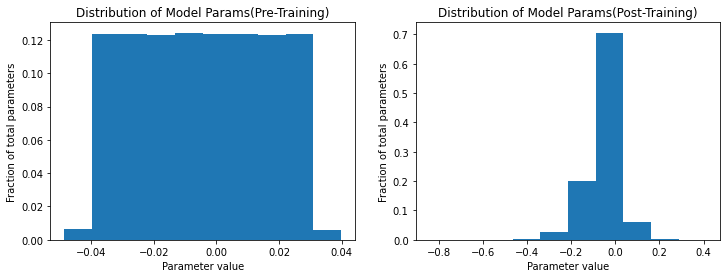

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.title('Distribution of Model Params(Pre-Training)')
plt.xlabel('Parameter value')
plt.ylabel('Fraction of total parameters')

counts_pre, bins_pre = np.histogram(pre_training_params, density=False)
probs_pre = counts_pre / counts_pre.sum()

plt.bar(bins_pre[:-1], probs_pre, bins_pre[1]-bins_pre[0])


plt.subplot(1,2,2)
plt.title('Distribution of Model Params(Post-Training)')
plt.xlabel('Parameter value')
plt.ylabel('Fraction of total parameters')

counts_post, bins_post = np.histogram(post_training_params, density=False)
probs_post = counts_post / counts_post.sum()

plt.bar(bins_post[:-1], probs_post, bins_post[1]-bins_post[0])

plt.show()

### Results
- The model has just one hidden layer. The initial distribution of the weights is uniform [Kaiming He][1]
- After training the distribution becaomes Gaussian-esque

[1]:https://pytorch.org/docs/stable/_modules/torch/nn/modules/linear.html#Linear